In [1]:
import json
from im2gps.data.flickr_repo import FlickrPhoto
from mongoengine import connect
import pandas as pd
from dataclasses import make_dataclass
import seaborn as sns
from random import sample
import matplotlib.pyplot as plt

from im2gps.data.data import ImageLoader

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
sns.set(font_scale=1.2)

In [3]:
path_to_results= "/home/andrew/Documents/study/thesis/thesis-src/output/localisation-results-k60-m5-s0025.json"
with open(path_to_results, 'r') as f:
    results = json.load(f)
print(results.keys())

dict_keys(['accuracy', 'errors', 'predictions_by_dist', 'img_dist_error', 'img_predicted_coords'])


# Accuracy by regions

In [4]:
connect(db="im2gps", host="localhost", port=51998)

MongoClient(host=['localhost:51998'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [5]:
ids = [int(photo_id) for photo_id in results['img_dist_error']]
by_regions = {region:[] for region in FlickrPhoto.objects.distinct(field="geo.region")}
no_region = []
for photo_id in ids:
    photo = FlickrPhoto.objects(photo_id=photo_id).first()
    if not photo.geo.region:
        no_region.append(photo.photo_id)
    else:
        by_regions[photo.geo.region].append(photo.photo_id)

In [8]:
Accuracy = make_dataclass("Accuracy", [("region", str), ("acc_10m", float), ("acc_100m", float), ("acc_500m", float), ("acc_1km", float), ("acc_5km", float)])
def get_accuracy_by_regions(input_dict, results):
    accuracy_by_region = {}
    for region in input_dict.keys():
        tmp = {
        "10m": [],
        "100m": [],
        "500m": [],
        "1km": [],
        "5km": []
        }
        for photo_id in input_dict[region]:
            dist = results["img_dist_error"][str(photo_id)]
            tmp['10m'].append(1 if dist <=0.01 else 0)
            tmp['100m'].append(1 if dist <=0.1 else 0)
            tmp['500m'].append(1 if dist <=0.5 else 0)
            tmp['1km'].append(1 if dist <=1 else 0)
            tmp['5km'].append(1 if dist <=5 else 0)

        accuracy_by_region[region] = {scale: -1 for scale in tmp.keys()}
        for scale, values in tmp.items():
            acc = sum(values)/len(values)

            accuracy_by_region[region][scale]=acc
        
    return accuracy_by_region

def accuracy_by_region_to_df(accuracy_by_region):
    accuracy_list = []
    for region, acc in accuracy_by_region.items():
        accuracy_list.append(Accuracy(region, acc['10m'], acc['100m'], acc['500m'], acc['1km'], acc['5km']))
    
    return pd.DataFrame(accuracy_list)

accuracy_by_region = get_accuracy_by_regions(by_regions, results)
accuracy_df = accuracy_by_region_to_df(accuracy_by_region)

region_cz_to_eng_map = {
    "Hlavní město Praha" : "Prague",
    "Středočeský kraj": "Central Bohemian Region",
    "Jihočeský kraj": "South Bohemian Region",
    "Plzeňský kraj": "Plzeň Region",
    "Karlovarský kraj": "Karlovy Vary Region",
    "Ústecký kraj": "Ústecký Region",
    "Liberecký kraj": "Liberec Region",
    "Královéhradecký kraj": "Hradec Králové Region",
    "Pardubický kraj": "Pardubice Region",
    "Kraj Vysočina": "Vysočina Region",
    "Jihomoravský kraj": "South Moravia Region",
    "Olomoucký kraj": "Olomouc Region",
    "Moravskoslezský kraj": "Moravian-Silesian Region",
    "Zlínský kraj": "Zlín Region"   
}

accuracy_df['region'] = accuracy_df["region"].map(region_cz_to_eng_map)

In [9]:
accuracy_df["id"]=accuracy_df.index
accuracy_df_long = pd.wide_to_long(accuracy_df, "acc", i="id", j="scale", sep="_", suffix='\w+').reset_index()
accuracy_df_long=accuracy_df_long.rename(columns={"scale": "Threshold"})
accuracy_df_long

,id,Threshold,region,acc
0,0,10m,Prague,0.028928
1,1,10m,South Moravia Region,0.000000
2,2,10m,South Bohemian Region,0.000000
3,3,10m,Karlovy Vary Region,0.000000
4,4,10m,Vysočina Region,0.000000
...,...,...,...,...
65,9,5km,Pardubice Region,0.000000
66,10,5km,Plzeň Region,0.142857
67,11,5km,Central Bohemian Region,0.448276
68,12,5km,Zlín Region,0.266667


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


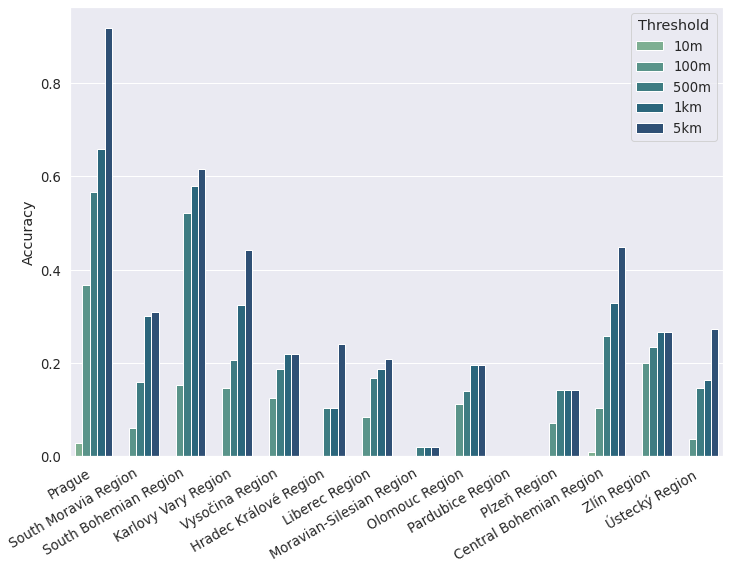

In [28]:
g=sns.barplot(data=accuracy_df_long.reset_index(), x="region", y="acc", hue="Threshold", palette='crest')
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');
g.set(xlabel='', ylabel='Accuracy')
g.get_figure().savefig('/home/andrew/Documents/study/thesis/thesis-images/4-baseline/kde_performance.eps', format='eps',bbox_inches='tight')

## Acurracy for Prague vs Other regions

In [11]:
prague_vs_other = {
"Hlavní město Praha": [],
"Other": []
}

for region in by_regions.keys():
    if region == "Hlavní město Praha":
        for photo_id in by_regions[region]:
            prague_vs_other[region].append(photo_id)
    else:
        for photo_id in by_regions[region]:
            prague_vs_other["Other"].append(photo_id)
            
accuracy_prague_v_other = get_accuracy_by_regions(prague_vs_other, results)
prague_v_other_df = accuracy_by_region_to_df(accuracy_prague_v_other)
prague_v_other_df

,region,acc_10m,acc_100m,acc_500m,acc_1km,acc_5km
0,Hlavní město Praha,0.028928,0.366206,0.565417,0.658120,0.917160
1,Other,0.001447,0.094067,0.238784,0.296671,0.347323


# Dependance between density and accuracy

In [12]:
densities_df = pd.read_csv("/home/andrew/Documents/study/thesis/thesis-src/results/test_densities.csv")
densities_df["id"] = densities_df.index
densities_df_long = pd.wide_to_long(densities_df, "density", i="id", j="density_level", sep="_", suffix='\w+').reset_index()
densities_df_long

,id,density_level,photo_id,density
0,0,10m,114761145,7
1,1,10m,114761148,7
2,2,10m,114761147,7
3,3,10m,114761146,7
4,4,10m,107623469,4
...,...,...,...,...
9219,2301,1km,50128720096,0
9220,2302,1km,50128150238,0
9221,2303,1km,50128149938,0
9222,2304,1km,50128938092,1


In [13]:
error_thresholds = {
    '0m to 10m': (0, 0.01),
    '10m to 100m': (0.01, 0.1),
    '100m to 500m': (0.1, 0.5),
    '500m to 1km': (0.5, 1.0),
    '1km to 5km': (1.0, 5.0),
    '5km to 10km': (5.0, 10.0),
    '10km+': (10.0, float('inf'))
}

by_distance_threshold = {}

for key in error_thresholds.keys():
    by_distance_threshold[key]=[]

for photo_id, dist in results["img_dist_error"].items():
    for level, limits in error_thresholds.items():
        left, right = limits
        if dist >= left and dist < right:
            by_distance_threshold[level].append(int(photo_id))

                

In [14]:
Record = make_dataclass('Record', [('predicted_within', str), ('photo_id', int)])
by_dist_thresholds_records = []
for threshold, ids in by_distance_threshold.items():
    for photo_id in ids:
        by_dist_thresholds_records.append(Record(threshold, photo_id))
        
by_dist_thresholds_df = pd.DataFrame(by_dist_thresholds_records)
by_dist_thresholds_df

,predicted_within,photo_id
0,0m to 10m,299656168
1,0m to 10m,299656170
2,0m to 10m,255799998
3,0m to 10m,390274876
4,0m to 10m,2705805422
...,...,...
2301,10km+,50122076902
2302,10km+,50128720096
2303,10km+,50128150238
2304,10km+,50128149938


In [15]:
by_dens_dist_levels_df = pd.merge(densities_df_long, by_dist_thresholds_df, on='photo_id')

by_dens_dist_levels_df = by_dens_dist_levels_df[by_dens_dist_levels_df['density_level'] == '1km']

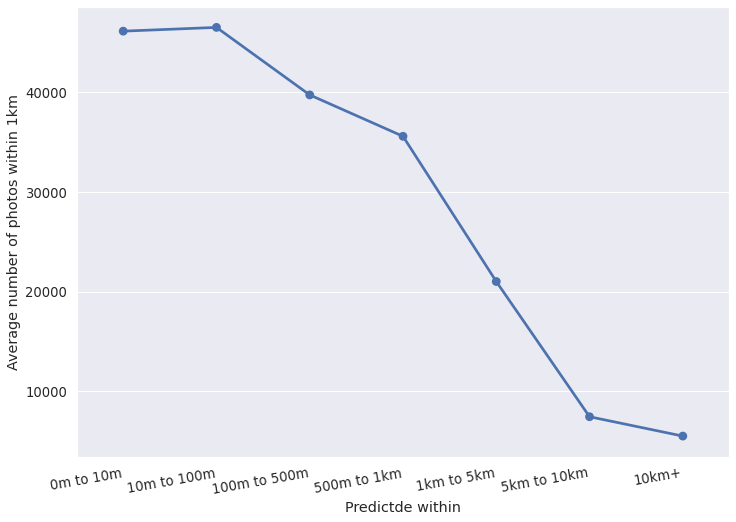

In [29]:
g=sns.pointplot(data=by_dens_dist_levels_df, x='predicted_within', y='density', ci=None, order=list(error_thresholds.keys()))
g.set(xlabel='Predictde within', ylabel='Average number of photos within 1km');
plt.xticks(rotation=10, ha='right');
g.get_figure().savefig('/home/andrew/Documents/study/thesis/thesis-images/4-baseline/density_vs_prediction.eps', format='eps',bbox_inches='tight')